In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import scanpy as sc
from scanpy import read_h5ad
import time as tm
import seaborn as sns
import logging
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# This function is identical to the SVM_import function from cPredictor (version 0.5.0)
def SVM_import(query_H5AD, OutputDir, SVM_type, replicates, sub_rep=None, colord=None, meta_atlas=False, show_bar=False, show_median=False):
    '''
    Imports the output of the SVM_predictor and saves it to the query_H5AD.

    Parameters:
    query_H5AD: H5AD file of datasets of interest.
    OutputDir: Output directory defining the path of the exported SVM_predictions.
    SVM_type: Type of SVM prediction, SVM (default) or SVMrej.
    Replicates: A string value specifying a column in query_H5AD.obs.
    colord: A .tsv file with the order of the meta_atlas and corresponding colors.
    meta_atlas : If the flag is added the predictions will use meta_atlas data.
    show_bar: Shows bar plots depending on the SVM_type, split over replicates.
    sub_rep:  A string value specifying an instance within the selected column in query_H5AD.obs.
    show_median: Shows the median values of the distribution of the predictions.

    '''
    logging.basicConfig(level=logging.DEBUG, 
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d/%m/%Y %H:%M:%S',
                        filename=f'{OutputDir}/cPredictor_import.log', filemode='w')
    logging.info('Reading query data')

    # Makes a figure dir in the output dir if it does not exist yet
    if not os.path.isdir(f"{OutputDir}/figures"):
        os.makedirs(f"{OutputDir}/figures")
    
    adata = read_h5ad(query_H5AD)
    SVM_key = f"{SVM_type}_predicted"

    # Load in the object and add the predicted labels
    logging.info('Adding predictions to query data')
    for file in os.listdir(OutputDir):
        if file.endswith('.csv'):
            if 'rej' not in file:
                filedir = OutputDir+file
                SVM_output_dir = pd.read_csv(filedir,sep=',',index_col=0)
                SVM_output_dir = SVM_output_dir.index.tolist()
                adata.obs["SVM_predicted"] = SVM_output_dir
            if 'rej_Pred' in file:
                filedir = OutputDir+file
                SVM_output_dir = pd.read_csv(filedir,sep=',',index_col=0)
                SVM_output_dir = SVM_output_dir.index.tolist()
                adata.obs["SVMrej_predicted"] = SVM_output_dir
            if 'rej_Prob' in file:
                filedir = OutputDir+file
                SVM_output_dir = pd.read_csv(filedir,sep=',',index_col=0)
                SVM_output_dir = SVM_output_dir.index.tolist()
                adata.obs["SVMrej_predicted_prob"]=SVM_output_dir

    # Set category colors:
    if meta_atlas is True and colord is not None:
        df_category_colors = pd.read_csv(colord, header=None,index_col=False, sep='\t')
        df_category_colors.columns = ['Category', 'Color']
        category_colors = dict(zip(df_category_colors['Category'], df_category_colors['Color']))
        if SVM_key == "SVMrej_predicted":
          category_colors["Unlabeled"] = "#808080"
                    
    if meta_atlas is False or colord is None:
    
      # Load a large color palette
      palette_name = "tab20"
      cmap = plt.get_cmap(palette_name)
      palette = [matplotlib.colors.rgb2hex(c) for c in cmap.colors] 
      
      # Extract the list of colors
      colors = palette
      key_cats = adata.obs[SVM_key].astype("category")
      key_list = key_cats.cat.categories.to_list()
            
      category_colors = dict(zip(key_list, colors[:len(key_list)]))
            
    # Plot absolute and relative barcharts across replicates
    logging.info('Plotting barcharts')
    if show_bar is True:
        sc.set_figure_params(figsize=(8, 5))
        
        key = SVM_key
        obs_1 = key
        obs_2 = replicates

        #n_categories = {x : len(adata.obs[x].cat.categories) for x in [obs_1, obs_2]}
        adata.obs[obs_1] = adata.obs[obs_1].astype("category")
        adata.obs[obs_2] = adata.obs[obs_2].astype("category")
        df = adata.obs[[obs_2, obs_1]].values

        obs2_clusters = adata.obs[obs_2].cat.categories.tolist()
        obs1_clusters = adata.obs[obs_1].cat.categories.tolist()
        obs1_to_obs2 = {k: np.zeros(len(obs2_clusters), dtype="i")
                           for k in obs1_clusters}
        obs2_to_obs1 = {k: np.zeros(len(obs1_clusters), dtype="i")
                           for k in obs2_clusters}
        obs2_to_obs1

        for b, v in df:
            obs2_to_obs1[b][obs1_clusters.index(str(v))] += 1
            obs1_to_obs2[v][obs2_clusters.index(str(b))] += 1

        df = pd.DataFrame.from_dict(obs2_to_obs1,orient = 'index').reset_index()
        df = df.set_index(["index"])
        df.columns = obs1_clusters
        df.index.names = ['Replicate']

        if meta_atlas is True and colord is not None:
            palette = category_colors
            if SVM_type == 'SVM' :
              ord_list = list(palette.keys())
              
            if SVM_type == 'SVMrej':
              ord_list = list(palette.keys())
            
            # Sorts the df on the longer ordered list
            def sort_small_list(long_list, small_list):
              sorted_list = sorted(small_list, key=lambda x: long_list.index(x))
              return sorted_list
            
            sorter = sort_small_list(ord_list, df.columns.tolist())
            
            # Retrieve the color codes from the sorted list
            lstval = [palette[key] for key in sorter]
            
            try:
              df = df[sorter]
            except KeyError:
              df = df
        else:
            lstval = list(category_colors.values())

        stacked_data = df.apply(lambda x: x*100/sum(x), axis=1)
        stacked_data = stacked_data.iloc[:, ::-1]

        fig, ax = plt.subplots(1,2)
        df.plot(kind="bar", stacked=True, ax=ax[0], legend = False,color=lstval, rot=45, title='Absolute number of cells')

        fig.legend(loc=7,title="Cell state")

        stacked_data.plot(kind="bar", stacked=True, legend = False, ax=ax[1],color=lstval[::-1], rot=45, title='Percentage of cells')

        fig.tight_layout()
        fig.subplots_adjust(right=0.9)
        fig.savefig(f"{OutputDir}/figures/{SVM_key}_bar.pdf", bbox_inches='tight')
        plt.close(fig)
    else:
        None

    if SVM_key == "SVM_predicted":
        logging.info('Plotting label prediction certainty scores')
        sns.set_theme(style='ticks')
        plt.rcParams['figure.figsize'] = 4,4

        # This allows for subsetting the density plot to individual instances of the replicates column
        if sub_rep is not None:
            adata = adata[adata.obs[replicates] == str(sub_rep)] # Add functional test here later

        # Iterate over each category and plot the density
        subset_joined = []
        for category, color in category_colors.items():
            subset = adata.obs[adata.obs['SVM_predicted'] == category]

            if show_median is True:
                label_name = f"{category} (Median: {subset['SVMrej_predicted_prob'].median():.2f})"
                
            if show_median is False:
                label_name = f"{category}"
                
            #subset[label_name] = subset["SVMrej_predicted_prob"]
            subset["Cell state"] = label_name
            subset = subset[["Cell state", "SVMrej_predicted_prob"]]
            subset_joined.append(subset)
            #ax.set(xlim=(0, 1))
        subset_joined = pd.concat(subset_joined)
        subset_joined = subset_joined.reset_index(drop=True)
        sns.displot(data=subset_joined, y="SVMrej_predicted_prob", hue="Cell state", kind="kde", cut=0,  #, fill=True
                    palette=category_colors, cumulative=True, common_norm=False, common_grid=True)

        # Set labels and title
        plt.xlabel('Density')
        plt.ylabel('SVM Certainty Scores')
        plt.title('Stacked Density Plots of Prediction Certainty Scores by Cell State')
        plt.ylim([0, 1])

        # Saving the density plot
        plt.savefig(f"{OutputDir}/figures/Density_prediction_scores.pdf", bbox_inches='tight')

    else:
        None
        
    logging.info('Saving H5AD file')
    adata.write_h5ad(f"{OutputDir}/{SVM_key}.h5ad")
    return

In [3]:
query_H5AD = sc.read_h5ad("/mnt/f/adultmaititest/maiti_adult_raw.h5ad")

In [4]:
query_H5AD

AnnData object with n_obs × n_vars = 90931 × 24922
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'biological_replicates'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

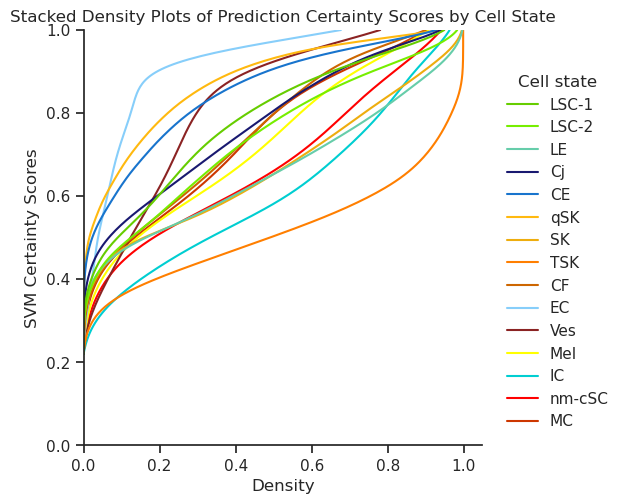

In [ ]:
sub = SVM_import("/mnt/f/adultmaititest/maiti_adult_raw.h5ad", "/mnt/f/adultmaititest/output/", "SVM", 'biological_replicates', sub_rep=None, colord="/mnt/f/adultmaititest/colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
#--colord data/colord.tsv --SVM_type SVM
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [6]:
# Calculate number of cells for each threshold (0-0.3;0.3-0.7;0.7-1.0)

In [7]:
processed_H5AD = sc.read_h5ad("/mnt/f/adultmaititest/SVM_predicted.h5ad")

In [8]:
processed_H5AD

AnnData object with n_obs × n_vars = 90931 × 24922
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'biological_replicates', 'SVM_predicted', 'SVMrej_predicted', 'SVMrej_predicted_prob'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [21]:
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

90931
Cells in lowest cat: 62, percentage:  0.06818356776016979
Cells in medium cat: 23012, percentage:  25.307100988661734
Cells in high cat: 67857, percentage:  74.6247154435781


# Maiti org 4 month

In [22]:
path_h5ad = "/mnt/f/organoidmaititest/maitiorg_noraw.h5ad"
output_path = "/mnt/f/organoidmaititest/output/"
query_H5AD = sc.read_h5ad(path_h5ad)

/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

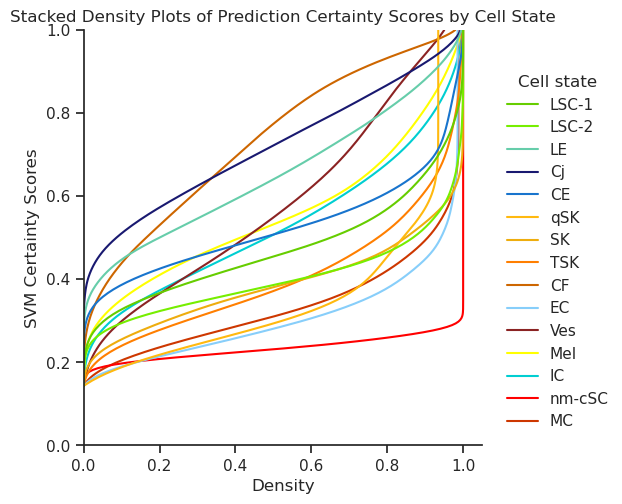

In [ ]:
sub = SVM_import(path_h5ad, output_path, "SVM", 'biological_replicates', sub_rep=None, colord=f"{output_path}colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [24]:
processed_H5AD = sc.read_h5ad("/mnt/f/organoidmaititest/output/SVM_predicted.h5ad")
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

Cells in lowest cat: 3157, percentage:  1.8460261028207885
Cells in medium cat: 78717, percentage:  46.02902652383403
Cells in high cat: 89142, percentage:  52.12494737334519


# Swarup organoid data

In [25]:
path_h5ad = "/mnt/f/organoidswarup/swaruporg_raw_small_nodoublets.h5ad"
output_path = "/mnt/f/organoidswarup/output/"
query_H5AD = sc.read_h5ad(path_h5ad)

In [26]:
# Load in the timepoint data
timepoint= pd.read_csv('/mnt/c/Users/jarts/Documents/cpred_model/orgswarup/timepoint.tsv',index_col=False,header=None)
timepoint

,0
0,m4
1,m4
2,m4
3,m4
4,m4
...,...
144699,m1
144700,m1
144701,m1
144702,m1


/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

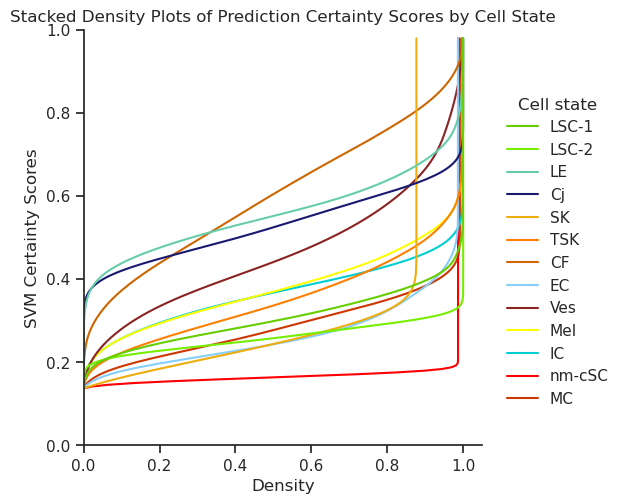

In [ ]:
sub = SVM_import(path_h5ad, output_path, "SVM", 'timepoint', sub_rep="m1", colord=f"{output_path}colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [28]:
processed_H5AD = sc.read_h5ad("/mnt/f/organoidswarup/output/SVM_predicted.h5ad")
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

Cells in lowest cat: 1968, percentage:  4.27807486631016
Cells in medium cat: 30597, percentage:  66.512325551063
Cells in high cat: 13437, percentage:  29.209599582626844


/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

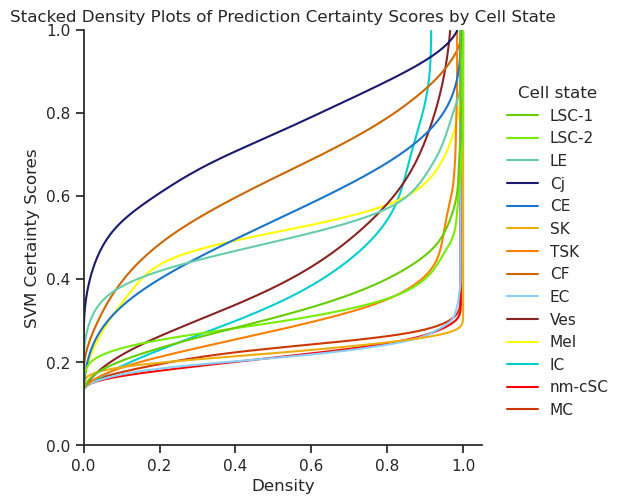

In [ ]:
sub = SVM_import(path_h5ad, output_path, "SVM", 'timepoint', sub_rep="m2", colord=f"{output_path}colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [36]:
processed_H5AD = sc.read_h5ad("/mnt/f/organoidswarup/output/SVM_predicted.h5ad")
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

Cells in lowest cat: 2669, percentage:  5.613865342952695
Cells in medium cat: 27751, percentage:  58.37031739688282
Cells in high cat: 17123, percentage:  36.01581726016448


/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

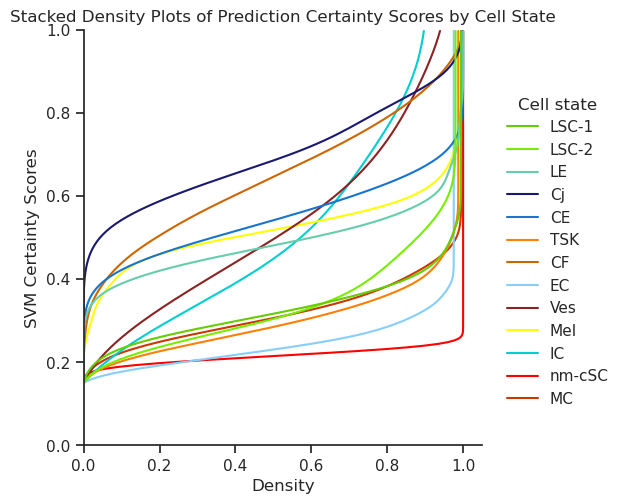

In [ ]:
sub = SVM_import(path_h5ad, output_path, "SVM", 'timepoint', sub_rep="m3", colord=f"{output_path}colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [32]:
processed_H5AD = sc.read_h5ad("/mnt/f/organoidswarup/output/SVM_predicted.h5ad")
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

Cells in lowest cat: 563, percentage:  1.4010202811994525
Cells in medium cat: 24852, percentage:  61.843971631205676
Cells in high cat: 14770, percentage:  36.755008087594874


/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cell state"] = label_name
/tmp/ipykernel_1790/1170806687.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

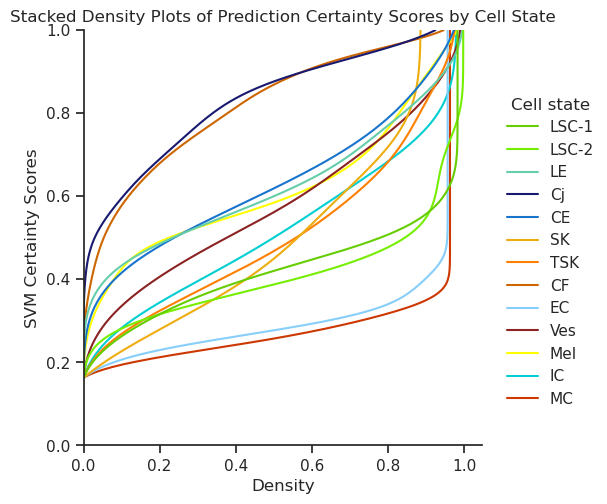

In [ ]:
sub = SVM_import(path_h5ad, output_path, "SVM", 'timepoint', sub_rep="m4", colord=f"{output_path}colord.tsv", meta_atlas=True, show_bar=False, show_median=False)
sub
# Small note: LE has been changed to LSE; EC to CEC and Ves to B/L EC in the final manuscript

In [34]:
processed_H5AD = sc.read_h5ad("/mnt/f/organoidswarup/output/SVM_predicted.h5ad")
total = sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)
count = sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in lowest cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.3)
print(f"Cells in medium cat: {count}, percentage: ", str(count/total*100))
count= sum(processed_H5AD.obs['SVMrej_predicted_prob'] <= 1.0)-sum(processed_H5AD.obs['SVMrej_predicted_prob'] < 0.7)
print(f"Cells in high cat: {count}, percentage: ", str(count/total*100))

Cells in lowest cat: 112, percentage:  1.3921690490988192
Cells in medium cat: 2844, percentage:  35.351149782473584
Cells in high cat: 5089, percentage:  63.2566811684276
